In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# to hide
import numpy as np
import matplotlib.pyplot as plt
import islets
from scipy.stats import distributions as dst

/opt/tljh/user/envs/physio_dev/lib/python3.7/site-packages/pims/image_reader.py:26: RuntimeWarning: PIMS image_reader.py could not find scikit-image. Falling back to matplotlib's imread(), which uses floats instead of integers. This may break your scripts. 
(To ignore this warning, include the line "warnings.simplefilter("ignore", RuntimeWarning)" in your script.)
  warnings.warn(RuntimeWarning(ski_preferred))


In [3]:
%%time
regions = islets.load_regions("/home/jupyter-srdjan/notebooks/receptors/bull_rois.pkl",calcInterest=False)

CPU times: user 9.28 s, sys: 1.21 s, total: 10.5 s
Wall time: 11.2 s


In [4]:
%config InlineBackend.figure_format='retina'

In [5]:
roi = 226

In [8]:
indices = [roi]
for _ in range(3):
    indices = sum(regions.df.loc[indices,"neighbors"],indices)
    indices = list(set(indices))

/home/srdjan/github/Physio_Ca/islets/Regions.py:648: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


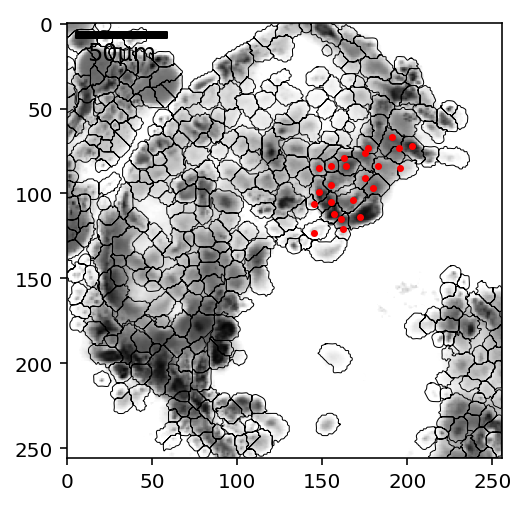

In [9]:
regions.plotEdges(color="k")
regions.plotPeaks(indices, ms=5,color="r")

In [10]:
regions.df = regions.df.loc[indices]
regions.update()

In [11]:
candidateEvents = islets.EventDistillery.sequential_filtering(regions, timescales=2**np.arange(0,9.01,.25))

defined: 1  1.19  1.41  1.68  2  2.38  2.83  3.36  4  4.76  5.66  6.73  8  9.51  11.3  13.5  16  19  22.6  26.9  32  38.1  45.3  53.8  64  76.1  90.5  108  128  152  181  215  256  304  362  431  512
##############################	 0:  ts = 1.0s
Nrebin=1
passing through traces: 0 1 2 
correcting z by 0.9367702412394032
##############################	 1:  ts = 1.19s
Nrebin=1
passing through traces: 0 dilating by 3
1 dilating by 3
2 dilating by 3

correcting z by 0.9423643931294247
smoothing with kernel 3
##############################	 2:  ts = 1.41s
Nrebin=1
passing through traces: 0 dilating by 3
1 dilating by 3
2 dilating by 3

correcting z by 0.9471771509563599
smoothing with kernel 3
##############################	 3:  ts = 1.68s
Nrebin=1
passing through traces: 0 dilating by 3
1 dilating by 3
2 dilating by 3

correcting z by 0.950630876875678
smoothing with kernel 3
##############################	 4:  ts = 2.0s
Nrebin=1
passing through traces: 0 dilating by 3
1 dilating by 3
2 dil

In [12]:
slows = [c for c in regions.df.columns if "slow" in c]

In [13]:
plt.rcParams["font.size"] = 8

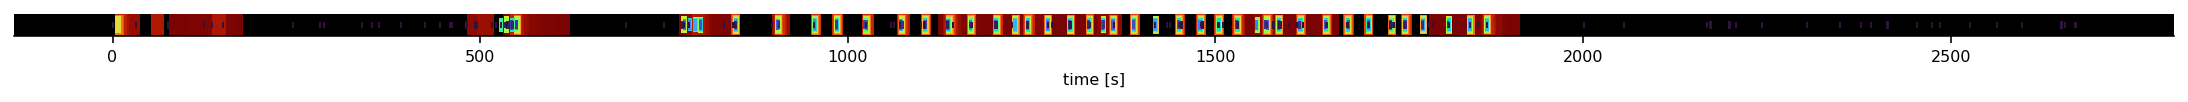

In [14]:
myEvents = candidateEvents.query(f"roi=={roi}").copy()
islets.EventDistillery.plot_events(myEvents, modify=True, cmap="turbo")

In [15]:
from matplotlib.ticker import MultipleLocator

In [16]:
myEvents_dist,_,myEvents_1 = islets.EventDistillery.distill_events_per_roi(myEvents, regions)

In [19]:
timescales = regions.timescales

In [20]:
def plot_traces(ax, onlyTrace=False):
    col = "trace"
    t = regions.time
    x = regions.df.loc[roi,col]
    dt = t[1]-t[0]
    showFreq = 4
    nrebin = int(1./(showFreq*dt))
    print (nrebin)
    if nrebin>1:
        t = islets.numeric.rebin(t, nrebin)
        x = islets.numeric.rebin(x, nrebin)
    ax.plot(t,x,
#             color=plt.cm.Greys(.8),
            color=(0,.1,0),
            lw=.4, zorder=10
           )
    if not onlyTrace:
        tms = regions.timescales[10:][::-1]
        for it,ts in enumerate(tms):
            t = regions.showTime.get("%g"%ts,regions.time)
            col = "slower_%g"%ts
            x = regions.df.loc[roi,col]
            dt = t[1]-t[0]
            showFreq = 2
            nrebin = int(1./(showFreq*dt))
            if nrebin>1:
                t = islets.numeric.rebin(t, nrebin)
                x = islets.numeric.rebin(x, nrebin)
            ax.plot(t,x,
#                     color=plt.cm.terrain(it/(len(tms)-1)),
                    color=plt.cm.Greys(it/(len(tms)-1)),
                    lw=.3
                   )
    for sp in ax.spines: ax.spines[sp].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])


4
4
4


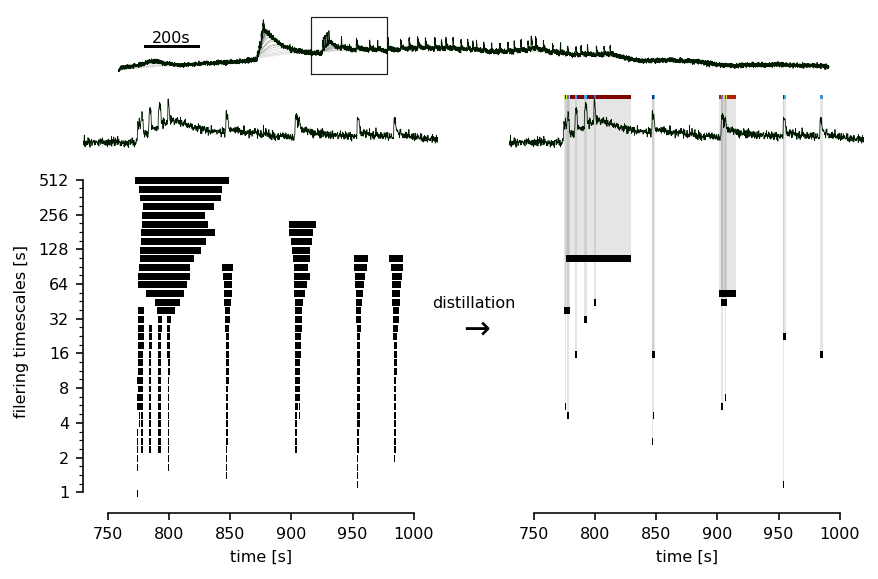

In [34]:
# ax = regions.plot_trace(roi, figsize=4, cols=["trace"])
fig, axs = plt.subplots(1,2,figsize=(7,4),)

xl,ddx = (480,1020),100
xl,ddx = (730,1020),50
plt.subplots_adjust(top=.85)
# plot_traces(axs[0])
# plot_traces(axs[1], onlyTrace=True)
for ir,row in myEvents.copy().iterrows():
    row['color'] = "k"
    islets.EventDistillery.draw_spike(row,axs[0])
ax = axs[1]
yl = axs[0].get_ylim()
for ir,row in myEvents_dist.copy().iterrows():
    if row.tend<xl[0]+20: continue
    row['color'] = "k"
    islets.EventDistillery.draw_spike(row,ax)
    ax.fill_between([row.t0,row.tend], yl[1]*100, row.its, alpha = .2,color="grey", lw=0, zorder=-1)
for ax in axs.flat:
    ax.set_xlim(xl)
    ax.set_ylim(yl[0],yl[1]*1.2)
axs[1].spines["left"].set_visible(False)
axs[1].set_yticks([])
axs[0].set_yticks(np.arange(len(timescales)), minor=True);
for ax in axs:
    axx = ax.twinx()
    plot_traces(axx,
                onlyTrace=True,
#                 onlyTrace=ax is axs[1]
               )
    yl = axx.get_ylim()
    dy = yl[1]-yl[0]
    axx.set_ylim(yl[0]-3*dy,yl[1]-.2*dy)
ymax = ax.get_ylim()[1]
for ir,row in myEvents_dist.copy().sort_values("halfwidth",ascending=False).iterrows():
    if row.tend<xl[0]+20: continue
    row["its"] = ymax
    islets.EventDistillery.draw_spike(row,ax,)
for ax in axs:
    ax.set_xlim(xl)
    timescales = regions.timescales
    if ax is axs[0]:
        ax.set_yticks([jt for jt,ts in enumerate(timescales) if int(np.log2(ts))==np.log2(ts)])
        ax.set_yticklabels(["%g"%ts for ts in timescales if int(np.log2(ts))==np.log2(ts)]);
#     ax.patch.set_alpha(0)
    for sp in ax.spines:
        if sp=="bottom":
            xt0,xt1 = np.round(xl[0]/ddx)*ddx, np.round(xl[1]/ddx)*(ddx+1)
            xt = np.arange(xt0,xt1,ddx)
            ax.spines[sp].set_bounds(xt[0],xt[-1])
            ax.set_xticks(xt)
        elif sp=="left":
            if ax is axs[0]:
                yt = ax.get_yticks()
                ax.spines[sp].set_bounds(0,yt[-1])
        else:
            ax.spines[sp].set_visible(False)
    ax.set_xlabel("time [s]")
ax.text(-.1,.5,"distillation",va="center",rotation=0,transform=ax.transAxes, ha="center")
ax.text(-.1,.44,r"$\rightarrow$",va="center",rotation=0,transform=ax.transAxes, ha="center", fontsize=16)
ax = axs[0]
ax.text(xl[0]-ddx,len(timescales)/2, "filering timescales [s]", va="center", ha="center", rotation=90)

bbox = axs[0].get_position()
orig = bbox.get_points()[0]
width = axs[1].get_position().get_points()[1][0]-orig[0]
h = bbox.height*.15
ax = fig.add_axes((orig[0], .99-h, width, h))
plot_traces(ax)
# for sp in ax.spines:
#     ax.spines[sp].set_visible(True)
ax.patch.set_alpha(0)
yl = ax.get_ylim()
ax.plot(
    [xl[0],xl[1],xl[1],xl[0],xl[0]],
    [yl[0],yl[0],yl[1],yl[1],yl[0]],
    color=plt.cm.Greys(.9),
    lw=.6,
)
xx = [100,300]
yy = np.mean(yl)
ax.plot(xx,[yy]*2,color="k")
ax.text(np.mean(xx),yy,"%is"%int(xx[1]-xx[0]),ha="center", va="bottom")
fig.savefig("figures/evdist_tmp.png", dpi=300)
fig.savefig("figures/evdist_tmp.pdf")

In [19]:
# # ax = regions.plot_trace(roi, figsize=4, cols=["trace"])
# fig, axs = plt.subplots(2,1,figsize=(7,5), gridspec_kw={"height_ratios":[1,2]}, sharex=True)

# plt.subplots_adjust(hspace=-.17)
# plot_traces(axs[0])
# for ir,row in myEvents.iterrows():
#     islets.EventDistillery.draw_spike(row,axs[1])

# ax = axs[1]
# ax.set_ylim(ax.get_ylim()[::-1])
# timescales = regions.timescales
# ax.set_yticks([jt for jt,ts in enumerate(timescales) if int(np.log2(ts))==np.log2(ts)])
# ax.set_yticklabels(["%g"%ts for ts in timescales if int(np.log2(ts))==np.log2(ts)]);
# ax.patch.set_alpha(0)

# ax.set_xlim(350,1150)
# for sp in ax.spines:
#     if sp=="bottom":
#         xt = ax.get_xticks()
#         ax.spines[sp].set_bounds(xt[1],xt[-2])
#     elif sp=="left":
#         yt = ax.get_yticks()
#         ax.spines[sp].set_bounds(1,yt[-1])
# #         ax.yaxis.set_minor_locator(MultipleLocator(1,))
#     else:
#         ax.spines[sp].set_visible(False)
# ax.set_xlabel("time [s]")
# # fig.savefig("tmp.png", dpi=300)

In [127]:
# # ax = regions.plot_trace(roi, figsize=4, cols=["trace"])
# fig, axs = plt.subplots(2,2,figsize=(7,4), gridspec_kw={"height_ratios":[1,2]}, sharey="row")
# xl = 480,1020

# plt.subplots_adjust(hspace=-.17, wspace=.1)
# plot_traces(axs[0,0])
# plot_traces(axs[0,1], onlyTrace=True)
# for ir,row in myEvents.copy().iterrows():
#     row['color'] = "k"
#     islets.EventDistillery.draw_spike(row,axs[1,0])
# for ir,row in myEvents_dist.copy().iterrows():
#     if row.tend<xl[0]+20: continue
#     row['color'] = "k"
#     islets.EventDistillery.draw_spike(row,axs[1,1])
#     for ax in axs[:1,1].flat:
#         yl = ax.get_ylim()
#         ax.fill_between([row.t0,row.tend], *yl, alpha = .1,color="grey")
#         ax.set_ylim(yl)
# for ax in axs.flat:
#     ax.set_xlim(xl)
# for ax in axs[1,:]:
#     ax.set_ylim(ax.get_ylim()[::-1])
#     timescales = regions.timescales
#     ax.set_yticks([jt for jt,ts in enumerate(timescales) if int(np.log2(ts))==np.log2(ts)])
#     ax.set_yticklabels(["%g"%ts for ts in timescales if int(np.log2(ts))==np.log2(ts)]);
#     ax.patch.set_alpha(0)
#     for sp in ax.spines:
#         if sp=="bottom":
#             xt = ax.get_xticks()
#             ax.spines[sp].set_bounds(xt[1],xt[-2])
#         elif sp=="left":
#             yt = ax.get_yticks()
#             ax.spines[sp].set_bounds(0,yt[-1])
#     #         ax.yaxis.set_minor_locator(MultipleLocator(1,))
#         else:
#             ax.spines[sp].set_visible(False)
#     ax.set_xlabel("time [s]")
# axs[1,1].spines["left"].set_visible(False)
# axs[1,1].set_yticks([])
# fig.savefig("tmp.png", dpi=300)